In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm # progression bar for for loop
import matplotlib.pyplot as plt

# ANN with 1 Hidden Layer

## Loading of Dataset

In [2]:
data = np.load("mnist.npz") # loading dataset

# assign dataset
x_train = data["x_train"] # shape : (60000, 784)
y_train = data["y_train"] # shape : (60000,)

x_test = data["x_test"]
y_test = data["y_test"]

# data normalization and flattening 
x_train = x_train / 255.0
x_train = x_train.reshape(-1, 28*28)

x_test = x_test / 255.0
x_test = x_test.reshape(-1, 28*28)

#one hotting for have 10 classes
y_train_onehot = np.eye(10)[y_train]
y_test_onehot = np.eye(10)[y_test]

## Initialisation

In [3]:
def initialization(X, hidden): # function initialisation of wheights of the ANN
	"""
	initialization(X, hidden) -> weights
	
	arg :	- X = features (60000, 784) matrice.
			- hidden = the number of hidden neurons.
	
	output : - wheights = the dict of all the matrices weights (W1, b1...).
	"""
	output=10
	n_input = X.shape[1]

	#first layer
	W1 = np.random.randn(hidden, n_input) * np.sqrt(1. / n_input)
	b1 = np.zeros((1, hidden))

	#second layer
	W2 = np.random.randn(output, hidden) * np.sqrt(1. / hidden)
	b2 = np.zeros((1, output))

	weights = {
		"W1" : W1,
		"b1" : b1,
		"W2" : W2,
		"b2" : b2
	}
	
	return weights

## Forward Prpagation

In [4]:
def sigmoid(z):
	return 1 / (1 + np.exp(-z))
def softmax(z):
	exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
	return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def forward_propagation(X, weights): # forward propagation function
	"""
	forward_propagation(X, weights) -> activations
	
	arg :	- X = features (60000, 784) matrice.
			- wheights = the dict of all the weights (W1, b1...).
	
	output : - activations = the dict of all activations matrices (A1, A2).
	"""
	W1 = weights["W1"]
	b1 = weights["b1"]
	W2 = weights["W2"]
	b2 = weights["b2"]

	#layer 0
	A0 = X # shape : (60000, 784)

	#first layer
	Z1 = A0 @ W1.T + b1 # shape : (60000, 784) @ (784, 10) + (1,10) = (60000, 10)
	A1 = sigmoid(Z1)

	#second layer
	Z2 = A1 @ W2.T + b2   # shape : (60000, 10) @ (10, 10) + (1,10) = (60000, 10)
	A2 = softmax(Z2)

	activations = {
		"A1" : A1,
		"A2" : A2
	}

	return activations

## Loss Function : Cross Entropy Loss

In [5]:
def cross_entropy_loss(activations, Y): # loss function
	"""
	cross_entropy_loss(activations, Y) -> loss

	arg :	- activations = the dict of all activations matrices (A1, A2).
			- Y = labels one hotted of the X features.
	
	output :	- loss = loss of the forward propagation.
	"""
	A = activations["A2"]
	m = Y.shape[0]
	
	# Pour éviter log(0)
	epsilon = 1e-9
	
	loss = -np.sum(Y * np.log(A + epsilon)) / m
	
	return loss

## Gradient

In [6]:
def gradient(X, Y, activations, weights):
	"""
	gradient(X, Y, activations, weights) -> gradients
	
	arg :	- X = features (60000, 784) matrice.
			- Y = labels one hotted of the X features.
			- activations = the dict of all activations matrices (A1, A2).
			- wheights = the dict of all the weights (W1, b1...).
			
	output :	- gradients = gradients of all parameters (weights), determine the way to go to update parameters.
	"""
	A1 = activations["A1"]
	A2 = activations["A2"]

	W2 = weights["W2"]

	m = X.shape[0]

										# d mean the partial derivative
	dZ2 = (A2 - Y) / m 						 # = (dLoss / dA2) * (dA2 / dZ2) easy derivative, cross entropy then softmax
	dW2 = A1.T @ dZ2						 # = (dLoss / dA2) * (dA2 / dZ2) * (dZ2 / dW2)
	db2 = np.sum(dZ2, axis=0, keepdims=True) # = (dLoss / dA2) * (dA2 / dZ2) * (dZ2 / db2)

	dA1 = dZ2 @ W2 						 # = (dLoss / dA2) * (dA2 / dZ2) * (dZ2 / dA1)
	dZ1 = dA1 * (A1 * (1 - A1)) 			 # = (dLoss / dA2) * (dA2 / dZ2) * (dZ2 / dA1) * (dA1 / dZ1)
	dW1 = X.T @ dZ1 						 # = (dLoss / dA2) * (dA2 / dZ2) * (dZ2 / dA1) * (dA1 / dZ1) * (dZ1 / dW1)
	db1 = np.sum(dZ1, axis=0, keepdims=True) # = (dLoss / dA2) * (dA2 / dZ2) * (dZ2 / dA1) * (dA1 / dZ1) * (dZ1 / db1)
	
	gradients = {
		"dW1" : dW1.T,
		"db1" : db1,
		"dW2" : dW2.T,
		"db2" : db2
	}


	return gradients

## Back Prpagation

In [7]:
def update(weights, gradients, learning_rate): # function for updating the weight of the model.
	"""
	gradient(X, Y, activations, weights) -> gradients
	
	arg :	- gradients = gradients of all parameters (weights);
			- wheights = the dict of all the weights (W1, b1...).
			- learning_rate = the speed of the learning (high : learning fast but bad for finding minimum, and low : learning slow but higher chance to find the minimum)
			
	output :	- wheights = the dict of all the weights (W1, b1...) update by the gradients.
	"""
	# update all parameters
	weights["W1"]-=learning_rate*gradients["dW1"]
	weights["b1"]-=learning_rate*gradients["db1"]

	weights["W2"]-=learning_rate*gradients["dW2"]
	weights["b2"]-=learning_rate*gradients["db2"]

	return weights

# Class Model

In [9]:
class Model:

	#initialization of the model
	def __init__(self, X, Y, hidden=100):
		self.X = X
		self.Y = Y
		self.weights = initialization(X,hidden)


	# function to fit the model and return loss
	def fit(self, n_iter=1000, learning_rate=0.1):
		cost = []
		for _ in tqdm(range(n_iter)):
			activations = forward_propagation(self.X, self.weights)
			gradients = gradient(self.X, self.Y,activations, self.weights)
			self.weights = update(self.weights, gradients, learning_rate)
			cost.append(cross_entropy_loss(activations, self.Y))
		return cost
		
	def predict(self, X):
		activations = forward_propagation(X, self.weights)
		return np.argmax(activations["A2"], axis=1)  # return the predict class (0-9)


	def score(self, X, y):
		y_pred = self.predict(X)
		return np.mean(y_pred == y)


# Testing the model

## Curve of Loss Function

100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s]


Text(0.5, 0, 'Number of itération')

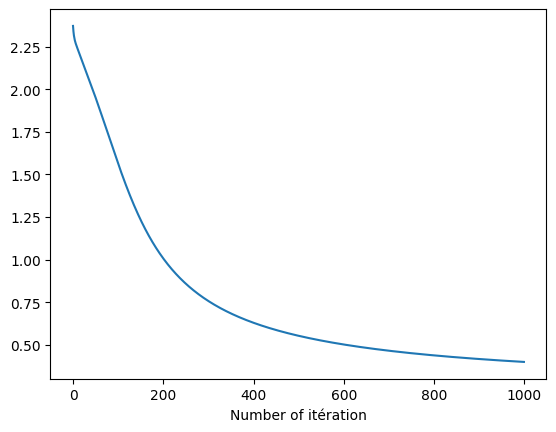

In [17]:
newModel = Model(x_train, y_train_onehot, hidden=100)
cost = newModel.fit(1000)
plt.plot(cost)
plt.xlabel("Number of itération")
# The loss of the model is indeed in the process of getting lower and lower results

## Differents Iterations Test

In [ ]:
# Test on different iterations
for i in range(100,1001,100):
	

	print(f"Test accuracy : {acc * 100:.2f}%")

"""
Test accuracy : 75.01% # 100 iter
Test accuracy : 80.64% # 200 iter
Test accuracy : 84.82% # 300 iter
Test accuracy : 86.59% # 400 iter
Test accuracy : 87.49% # 500 iter
Test accuracy : 88.49% # 600 iter
Test accuracy : 88.96% # 700 iter
Test accuracy : 89.43% # 800 iter
Test accuracy : 89.65% # 900 iter
Test accuracy : 89.89% # 1000 iter

the model improves on different iterations
this seems that the model is good
"""

100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


Précision sur le test : 75.01%


100%|██████████| 200/200 [00:30<00:00,  6.57it/s]


Précision sur le test : 80.64%


100%|██████████| 300/300 [00:46<00:00,  6.45it/s]


Précision sur le test : 84.82%


100%|██████████| 400/400 [01:02<00:00,  6.40it/s]


Précision sur le test : 86.59%


100%|██████████| 500/500 [01:18<00:00,  6.40it/s]


Précision sur le test : 87.49%


100%|██████████| 600/600 [01:27<00:00,  6.84it/s]


Précision sur le test : 88.49%


100%|██████████| 700/700 [01:41<00:00,  6.87it/s]


Précision sur le test : 88.96%


100%|██████████| 800/800 [01:56<00:00,  6.86it/s]


Précision sur le test : 89.43%


100%|██████████| 900/900 [02:16<00:00,  6.60it/s]


Précision sur le test : 89.65%


100%|██████████| 1000/1000 [02:27<00:00,  6.76it/s]

Précision sur le test : 89.89%


## Table showing accuracy as a function of iteration and hidden neurons

In [ ]:
""" 
Create a test to show different accuracy score on to param : hidden and iter

I want to create a tab of accuracy score when two parameters change independently
"""
accuracy_tab = []
hidden_tab = [50,100,200,500]
iter_tab = [200,500,1000]
for h in hidden_tab :
	
	temp_all_iter=[]
	model = (Model(x_train,y_train_onehot,h))
	iter_temp = 0 # I create iter_temp to use the same model on different iterations.
	for i in iter_tab :
		
		print("fitting on",h,"hidden neurons and",i,"iterations")
		model.fit(i-iter_temp) # to train 500 times the model, it is 200 iter + 500 - 200 = 500
	
		acc = model.score(x_test, y_test)
		temp_all_iter.append(acc)

		iter_temp = i
	accuracy_tab.append(temp_all_iter)
accuracy_tab


fitting on 50 hidden neurons and 200 iterations


100%|██████████| 200/200 [00:22<00:00,  8.72it/s]


fitting on 50 hidden neurons and 500 iterations


100%|██████████| 300/300 [00:34<00:00,  8.73it/s]


fitting on 50 hidden neurons and 1000 iterations


100%|██████████| 500/500 [00:55<00:00,  8.97it/s]


fitting on 100 hidden neurons and 200 iterations


100%|██████████| 200/200 [00:30<00:00,  6.51it/s]


fitting on 100 hidden neurons and 500 iterations


100%|██████████| 300/300 [00:44<00:00,  6.71it/s]


fitting on 100 hidden neurons and 1000 iterations


100%|██████████| 500/500 [01:15<00:00,  6.65it/s]


fitting on 200 hidden neurons and 200 iterations


100%|██████████| 200/200 [00:53<00:00,  3.74it/s]


fitting on 200 hidden neurons and 500 iterations


100%|██████████| 300/300 [01:20<00:00,  3.73it/s]


fitting on 200 hidden neurons and 1000 iterations


100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


fitting on 500 hidden neurons and 200 iterations


100%|██████████| 200/200 [02:05<00:00,  1.59it/s]


fitting on 500 hidden neurons and 500 iterations


100%|██████████| 300/300 [03:05<00:00,  1.61it/s]


fitting on 500 hidden neurons and 1000 iterations


100%|██████████| 500/500 [05:10<00:00,  1.61it/s]


[[np.float64(0.7983), np.float64(0.8707), np.float64(0.9004)],
 [np.float64(0.8184), np.float64(0.8764), np.float64(0.9002)],
 [np.float64(0.8207), np.float64(0.879), np.float64(0.8991)],
 [np.float64(0.8417), np.float64(0.8854), np.float64(0.8996)]]

In [ ]:
# Creation of table
df = pd.DataFrame(accuracy_tab, index=hidden_tab, columns=iter_tab)

df.index.name = 'Neurones cachés'
df.columns.name = 'Itérations'

print(df)

Itérations         200     500     1000
Neurones cachés                        
50               0.7983  0.8707  0.9004
100              0.8184  0.8764  0.9002
200              0.8207  0.8790  0.8991
500              0.8417  0.8854  0.8996


## Test on 2 learning rates

In [ ]:
model = Model(x_train, y_train_onehot, hidden=150)
model.fit(n_iter=500,learning_rate=0.1)
print(model.score(x_test,y_test))

model = Model(x_train, y_train_onehot, hidden=150)
model.fit(n_iter=500,learning_rate=0.01)
print(model.score(x_test,y_test))

100%|██████████| 500/500 [01:50<00:00,  4.53it/s]


0.8791


100%|██████████| 500/500 [01:50<00:00,  4.54it/s]

0.678


## Visualization of prediction number by number

In [ ]:

model = Model(x_train, y_train_onehot, hidden=150)
model.fit(n_iter=500,learning_rate=0.1)
nb_gd_predict =  [0,0,0,0,0,0,0,0,0,0]
nb_bad_predict = [0,0,0,0,0,0,0,0,0,0]
for x,y in zip(x_test,y_test):
	if model.predict(x)==y :
		nb_gd_predict[y]+=1
	else :
		nb_bad_predict[y]+=1

100%|██████████| 500/500 [01:49<00:00,  4.56it/s]


In [27]:
pc_nb_by_nb = []
for i in range(10):
	pc_nb_by_nb.append(nb_bad_predict[i]/ (nb_bad_predict[i] + nb_gd_predict[i]))
pc_nb_by_nb = np.array(pc_nb_by_nb).reshape(1, 10)

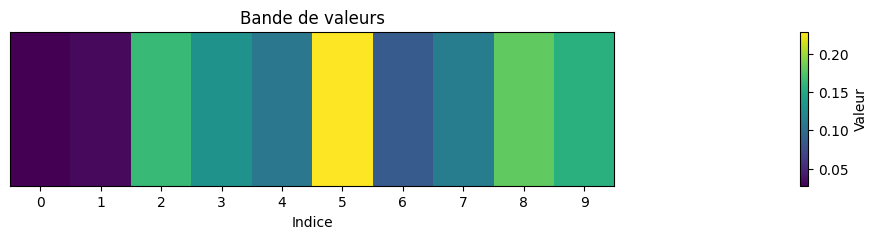

In [ ]:
plt.figure(figsize=(12, 2))
plt.imshow(pc_nb_by_nb, aspect='auto')

plt.yticks([])
plt.xticks(range(10))

plt.colorbar(label='Valeur', orientation='vertical', pad=0.2)
plt.title('Bande de valeurs')
plt.xlabel('Indice')

plt.show()
print("Top Worst Prediction : \n ")